# PAPER PRESENTATION : VoxelMorph

<img src="https://i.imgur.com/znFbwLj.gif" align="right" width="150"/>

## VoxelMorph: A Learning Framework for Deformable Medical Image Registration
📝 Paper: [https://arxiv.org/pdf/1809.05231.pdf](https://arxiv.org/pdf/1809.05231.pdf)

### **🎯 What?**

Pairwise medical image registration. Image registration, also known as image fusion or image matching, is the process of aligning two or more images based on image appearances. Medical Image Registration seeks to find an optimal spatial transformation that best aligns the underlying anatomical structures. in other words, is the process of finding is the process of finding optimal transformation that puts different images optimal transformation that puts different images into spatial correspondence.

### **❓ Why?**

Medical Image Registration is used in many clinical applications such as image guidance, motion tracking, segmentation, dose accumulation, image reconstruction and so on.

### ☝🏻 **Pior work and SoTa**

Modelled the matching as an optimisation problem with an objective function. 

(-) cons : inference take time (few minutes by using GPU)

### **🥊 Proposed solution**

Use CNN to learn to generate the deformable field. Then applied it the the moving images.

(+) pros : Fast inference (under second using GPU), accuracy close to sota

### ⚙️ Architecture

The deformation field is generate by U-net architecture

![model](https://i.imgur.com/IFkkNRZ.png)

The loss can be decomposed in two component : A image level similarly measure and the deformation field smoothness measure.

There two possible similarity measure : MSE and Cross-correlation


### **🦾 Results**

**Metrics :** The evaluation metric is the Dice score on anatomical segmentation. This measure in a certain way measure the volume overlap.

**Experimental setup :** They did an atlas based registration. This means that we take the atlas model of the brain as reference and we try to transform our input to that reference.

They use an atlas computed using an external dataset . Each input volume pair consists of the atlas (image f) and a volume from the dataset (image m). image pairs using the same fixed atlas for all examples. 

Best hyperparameter : 

# Baseline on MNIST

In [150]:
from scripts.mnist.data_loader import MNISTData
from scripts.mnist.voxelmorph import build_vxm, train_vxm
from scripts.mnist.utils import to_nametuple, multi_props_bij, Dice, jacobian_det

In [151]:
import os
import torch
import numpy as np
import neurite as ne
import matplotlib.pyplot as plt
from torchsummary import summary

device = 'cpu'
if device=="cuda":
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # enabling cudnn determinism appears to speed up training by a lot
    torch.backends.cudnn.deterministic = True

## 🎚️ Hyperparameter

In [152]:
conf = to_nametuple({
    # train
    'lr': 1e-3,
    'ndim': 2,
    'epochs': 10,
    'batch_size_train': 32,
    'log_interval': 10,
    'steps_per_epoch': 100,
    'device': 'cpu',
    'inshape': (32, 32),

    # Model
    'λ': 0.5,
    'image_loss': "mse",
    'model_dir': "."
})

## 🗄️ The Data

In [153]:
mnist_data = MNISTData()

##  Model for same source distribution 1️⃣ $\rightarrow$ 1️⃣ 

In [154]:
fix_digit = 5
moving_digit = 5

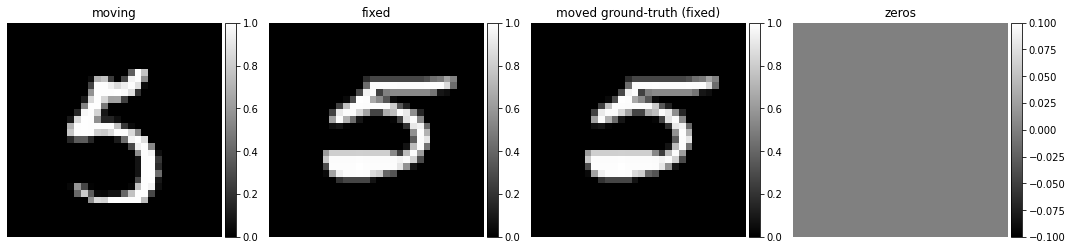

In [155]:
# Dataset
x_train, x_val = mnist_data.train_val(fix_digit, moving_digit)

# Plot
x_fix = next(x_train['fix'])[1].squeeze().numpy()
x_mvt = next(x_train['moving'])[1].squeeze().numpy()
zero_phi = np.zeros([*conf.inshape])

images = [x_mvt, x_fix, x_fix, zero_phi]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

### 🧠 Model

In [157]:
trainer = build_vxm(conf)
summary(trainer.model, [(1,32,32), (1,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             608
         LeakyReLU-2           [-1, 32, 16, 16]               0
         ConvBlock-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           9,248
         LeakyReLU-5             [-1, 32, 8, 8]               0
         ConvBlock-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
         LeakyReLU-8             [-1, 32, 4, 4]               0
         ConvBlock-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 32, 2, 2]           9,248
        LeakyReLU-11             [-1, 32, 2, 2]               0
        ConvBlock-12             [-1, 32, 2, 2]               0
           Conv2d-13             [-1, 32, 2, 2]           9,248
        LeakyReLU-14             [-1, 3

### 📉 Training

In [158]:
hist = train_vxm(conf, trainer, x_train)

epoch: 0001  step: 1/100     loss: 0.097679 
epoch: 0002  step: 1/100     loss: 0.055751 
epoch: 0003  step: 1/100     loss: 0.034490 
epoch: 0004  step: 1/100     loss: 0.034753 
epoch: 0005  step: 1/100     loss: 0.037072 
epoch: 0006  step: 1/100     loss: 0.039326 
epoch: 0007  step: 1/100     loss: 0.037634 
epoch: 0008  step: 1/100     loss: 0.031089 
epoch: 0009  step: 1/100     loss: 0.028086 
epoch: 0010  step: 1/100     loss: 0.036455 


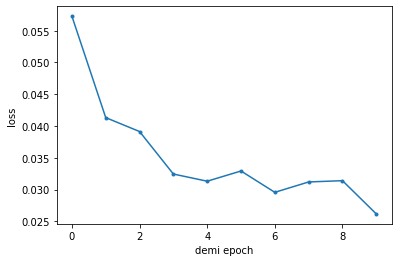

In [159]:
plt.figure()
plt.plot(np.arange(len(hist)), hist, '.-')
plt.ylabel('loss')
plt.xlabel('demi epoch')
plt.show()

### 🧪 Evaluation

In [160]:
from matplotlib import colors

In [161]:
def evaluate(trainer, data):
    fix = next(data['fix'])[:1,...]
    moving = next(data['moving'])[:1,...]

    with torch.no_grad():
        moved, flow = trainer.model(moving, fix)
        
    jacobian = jacobian_det(flow)
    
    images = [img[0,0,:,:].detach().numpy() for img in [moving, fix, moved]] 
    titles = ['moving', 'fixed', 'moved', 'jacobian', 'jacobian (binary)']
    cmaps = ['gray', 'gray', 'gray', 'RdBu', 'RdYlGn']
    norms = [colors.Normalize(vmin=vmin, vmax=vmax) for vmin, vmax in [[0,1], [0,1], [0,1], [-1,1], [0,1]] ]
    
    ne.plot.slices([*images, jacobian, 1*(jacobian>0.01)], titles=titles, 
                   norms = norms, cmaps=cmaps, do_colorbars=True);

    ## Eval
    print("Flow :")
    ne.plot.flow([flow.squeeze().permute(1, 2, 0)], width=4);
    print("Injectivity indicator : ",100*(1-multi_props_bij(trainer.model, data)))
    moved, fixed = moved[0,0,:,:].detach().numpy(), fix[0,0,:,:].detach().numpy()
    print("DICE score %.2f"%Dice(moved, fixed))

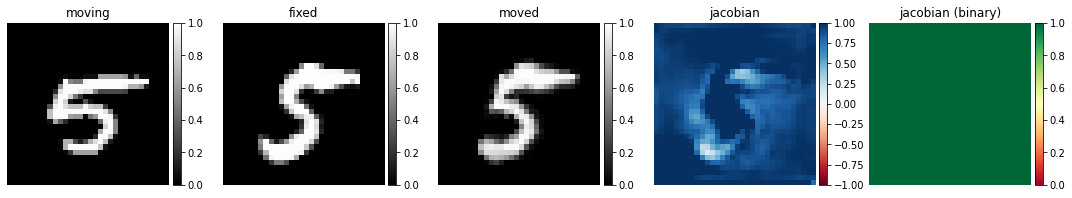

Flow :


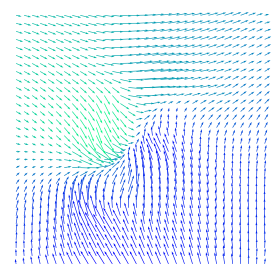

Injectivity indicator :  86.2158203125
DICE score 0.84


In [162]:
evaluate(trainer, x_val)

#### Generalisation 

##### Same number

* Same topology as the trainig data

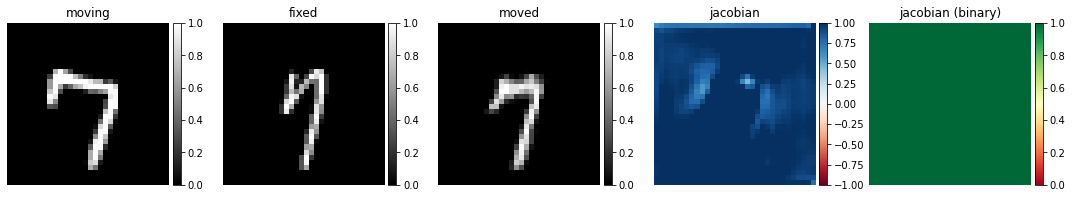

Flow :


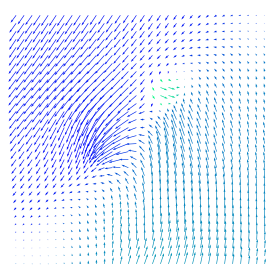

Injectivity indicator :  89.5703125
DICE score 0.78


In [163]:
digit = 7
test_data = mnist_data.test_data(fix=digit, moving=digit)

evaluate(trainer, test_data)

* Topology differ from the trainig data

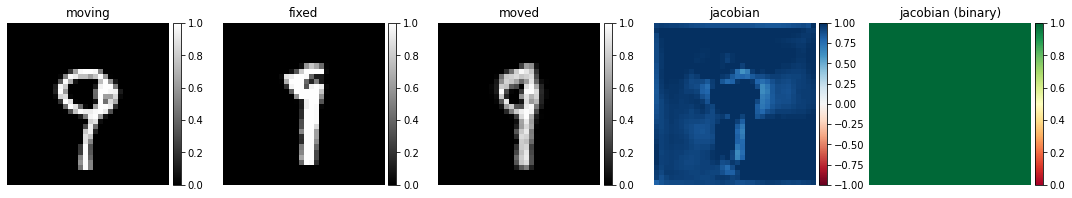

Flow :


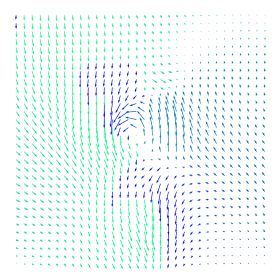

Injectivity indicator :  90.0830078125
DICE score 0.80


In [164]:
digit = 9
test_data = mnist_data.test_data(fix=digit, moving=digit)

evaluate(trainer, test_data)

##### Different number

* same topology

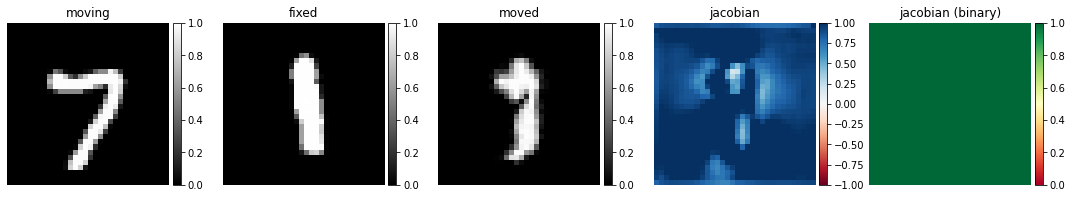

Flow :


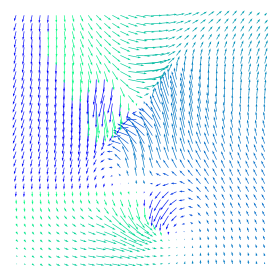

Injectivity indicator :  88.84765625
DICE score 0.78


In [165]:
test_data = mnist_data.test_data(fix=1, moving=7)

evaluate(trainer, test_data)

* Different topology

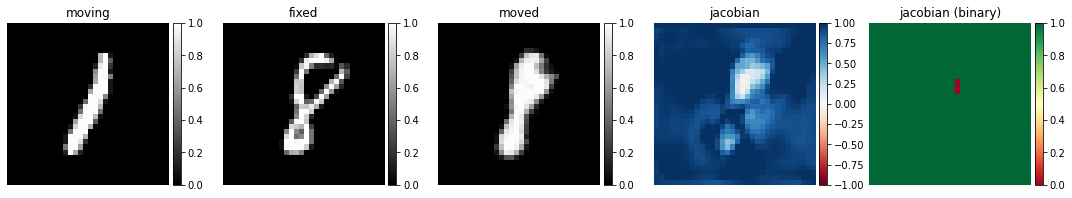

Flow :


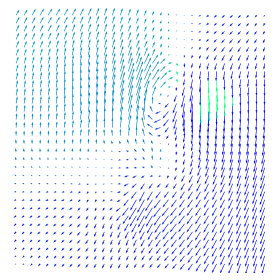

Injectivity indicator :  91.4794921875
DICE score 0.79


In [166]:
test_data = mnist_data.test_data(fix=8, moving=1)

evaluate(trainer, test_data)

##  Model for different topology distribution 1️⃣ $\rightarrow$ 8️⃣

In [170]:
fix_digit = 8
moving_digit = 5

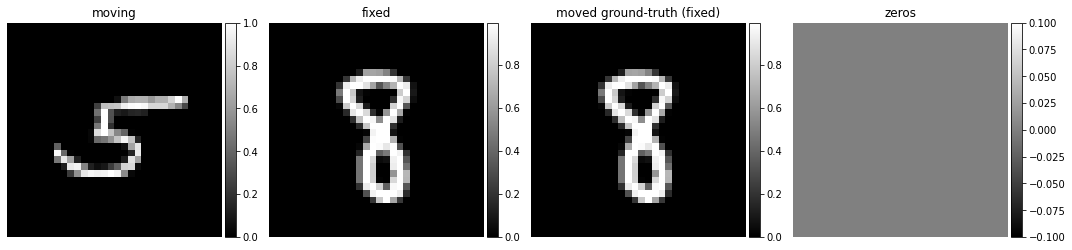

In [171]:
# Dataset
x_train, x_val = mnist_data.train_val(fix_digit, moving_digit)

# Plot
x_fix = next(x_train['fix'])[1].squeeze().numpy()
x_mvt = next(x_train['moving'])[1].squeeze().numpy()
zero_phi = np.zeros([*conf.inshape])

images = [x_mvt, x_fix, x_fix, zero_phi]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

### 🧠 Model

In [177]:
conf = conf._replace(λ=0.05)
trainer = build_vxm(conf)
summary(trainer.model, [(1,32,32), (1,32,32)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             608
         LeakyReLU-2           [-1, 32, 16, 16]               0
         ConvBlock-3           [-1, 32, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           9,248
         LeakyReLU-5             [-1, 32, 8, 8]               0
         ConvBlock-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 32, 4, 4]           9,248
         LeakyReLU-8             [-1, 32, 4, 4]               0
         ConvBlock-9             [-1, 32, 4, 4]               0
           Conv2d-10             [-1, 32, 2, 2]           9,248
        LeakyReLU-11             [-1, 32, 2, 2]               0
        ConvBlock-12             [-1, 32, 2, 2]               0
           Conv2d-13             [-1, 32, 2, 2]           9,248
        LeakyReLU-14             [-1, 3

### 📉 Training

In [178]:
hist = train_vxm(conf, trainer, x_train)

epoch: 0001  step: 1/100     loss: 0.104392 
epoch: 0002  step: 1/100     loss: 0.039618 
epoch: 0003  step: 1/100     loss: 0.026036 
epoch: 0004  step: 1/100     loss: 0.022536 
epoch: 0005  step: 1/100     loss: 0.019415 
epoch: 0006  step: 1/100     loss: 0.018506 
epoch: 0007  step: 1/100     loss: 0.018694 
epoch: 0008  step: 1/100     loss: 0.017006 
epoch: 0009  step: 1/100     loss: 0.016705 
epoch: 0010  step: 1/100     loss: 0.015997 


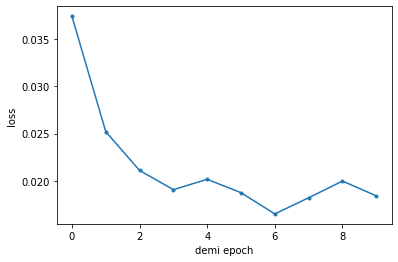

In [179]:
plt.figure()
plt.plot(np.arange(len(hist)), hist, '.-')
plt.ylabel('loss')
plt.xlabel('demi epoch')
plt.show()

### 🧪 Evaluation

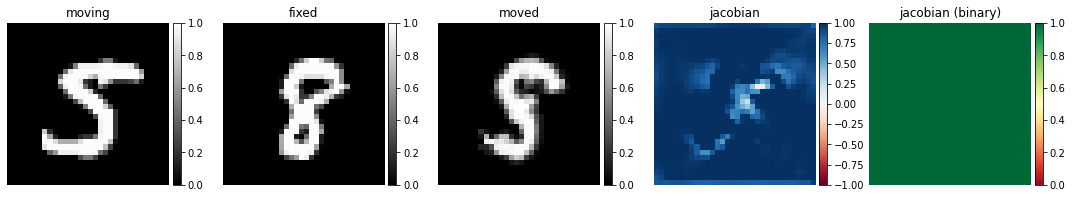

Flow :


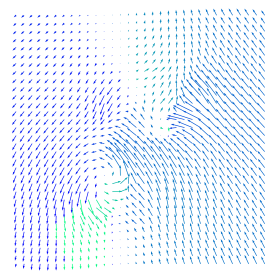

Injectivity indicator :  86.6748046875
DICE score 0.82


In [176]:
evaluate(trainer, x_val)

#### Generalisation 

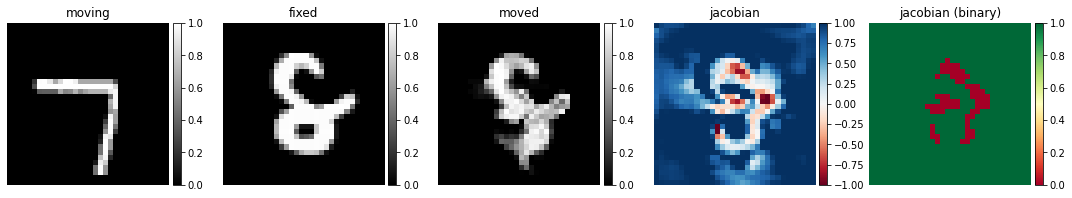

Flow :


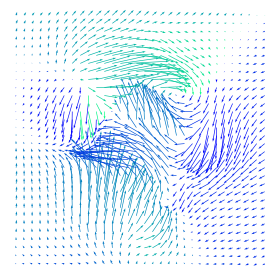

Injectivity indicator :  84.3994140625
DICE score 0.81


In [180]:
test_data = mnist_data.test_data(fix=8, moving=7)

evaluate(trainer, test_data)

# Train on Brain Image 

## The brain data

In [ ]:
%%capture
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

In [ ]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
inshape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


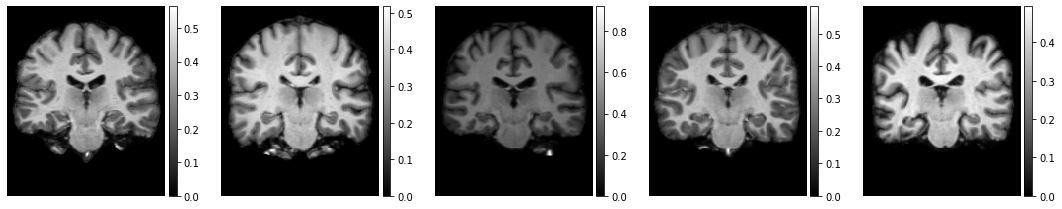

In [ ]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);